In [0]:
# default_exp data.exploratory.se.metrics

# Exploration of your data

> This module comprises some of the statistical and inference techniques to describe the inner properties of software data. The submodules might include:
>
> - Descriptive statistics
> - Software Metrics
> - Information Theory
> - Learning Principels Detection (Occams' Razor, Biased data, and Data Snooping)
> - Inference: Probabilistic and Causal

### Specifically in this module

> - Cyclomatic complexity (CYCLO)
> - Coupling Between Objects (CBO)
> - Lack of Cohesion of Methods 5 (LCOM5)
> - Top/Least 20 Occurring Tokens
> - Percentage of redundancy (just Java)
> - How many Type I and Type II clones are in Java datasets?

In [0]:
# #hide
# from nbdev.showdoc import *

In [3]:
!pip install sentencepiece
# !pip install metrics
!pip install lizard

In [0]:
# export
# Imports
import pandas as pd
import sentencepiece as sp
from numpy import mean, std
from statistics import median
from scipy.stats import sem, t
import lizard
import matplotlib.pyplot as plt

# TODO: Remove when mongo call is implemented
import os

In [0]:
# TODO: Replace with actual mongo call
def simulate_getting_dataframes_from_mongo():
    corpus_data = {"system": [], "name": [], "ground_truth": [], "contents": []}
    path = "./good"
    for file in os.listdir(path):
        corpus_data["system"].append(None)
        corpus_data["name"].append(file)
        corpus_data["ground_truth"].append("src")
        try:
            with open (os.path.join(path, file), "r", encoding='utf-8') as f:
                corpus_data['contents'].append(f.read())
        except UnicodeDecodeError:
            with open (os.path.join(path, file), "r", encoding='iso-8859-15') as f:
                corpus_data['contents'].append(f.read())
    path = "./tests"
    for file in os.listdir(path):
        corpus_data["system"].append(None)
        corpus_data["name"].append(file)
        corpus_data["ground_truth"].append("test")
        try:
            with open (os.path.join(path, file), "r", encoding='utf-8') as f:
                corpus_data["contents"].append(f.read())
        except UnicodeDecodeError:
            with open (os.path.join(path, file), "r", encoding='utf-16') as f:
                corpus_data["contents"].append(f.read())
    corpus_df = pd.DataFrame(data = corpus_data)
    return corpus_df

In [0]:
# export
def add_length_col(df, col, length_col_name='length'):
    """Adds a length column with the length of entries in the specified column of a dataframe"""
    df[length_col_name] = df[col].astype(str).apply(len)
    return df

In [0]:
# export
def add_mccabe_metrics(df, col):
    """Adds information about function length and cyclomatic complexity to the corpus dataframe"""
    file_ccn = []
    file_nloc = []
    num_funcs = []
    avg_func_ccn = []
    avg_func_nloc = []
    # avg_func_tok_count = [] # TODO: Figure out how lizard tokenizes
    for i in range(len(df)):
        metrics = lizard.analyze_file.analyze_source_code(df["name"][i], df["contents"][i])
        file_ccn.append(metrics.CCN)
        file_nloc.append(metrics.nloc)
        num_funcs.append(len(metrics.function_list))
        avg_func_ccn.append(metrics.average_cyclomatic_complexity)
        avg_func_nloc.append(metrics.average_nloc)
        # avg_func_tok_count.append(metrics.average_token_count) # TODO: Figure out how lizard tokenizes
    df["file_ccn"] = file_ccn
    df["file_nloc"] = file_nloc
    df["num_funcs"] = num_funcs
    df["avg_func_ccn"] = avg_func_ccn
    df["avg_func_nloc"] = avg_func_nloc
    # df["avg_func_tok_count"] = avg_func_tok_count # TODO: Figure out how lizard tokenizes
    return df

In [0]:
# export
def display_stats(df, col, data_types=None, conf = 0.95, sig_figs = 4):
    """Computes statistical metrics about the entries in a dataframe column"""
    if data_types: 
        df = df[df['ground_truth'].isin(data_types)]
        print(f"~~Printing metrics for {data_types} in column [{col}]~~")
    else:
        print(f"~~Printing metrics for all data in column [{col}]~~")

    print("Min =", round(df[col].min(), sig_figs))
    print("Max =", round(df[col].max(), sig_figs))
    print("Average =", round(df[col].mean(), sig_figs))
    print("Median =", round(median(df[col]), sig_figs))
    print("Standard Deviation =", round(std(df[col]), sig_figs))
    
    n = len(df[col])
    m = mean(df[col])
    std_err = sem(df[col])
    h = std_err * t.ppf((1 + conf) / 2, n - 1)

    start = m - h
    end = m + h
    print(f"{conf} of data points fall between {round(start, sig_figs)} and {round(end, sig_figs)}")

In [0]:
#export
def display_hist(df, col, bins=None):
    '''Displays a histogram with a customized number of bins for the data in a specified dataframe column'''
    rng = df[col].max() - df[col].min()
    num = len(df[col])
    stnd_dev = std(df[col])
    num_bins = round((rng*(pow(num,1/3)))/(3.49*stnd_dev)) # Bins calculated according to https://academic.oup.com/biomet/article-abstract/66/3/605/232642
    print(num_bins)
    plt.hist(df[col], num_bins, color="blue", alpha=0.5, edgecolor="black", linewidth=1.0)
    plt.title(col + "  histogram")
    plt.ylabel("value  occurrences")
    plt.xlabel("file  " + col)
    plt.show()

# Analysis & Visualization

In [10]:
# Retrieve the data
corpus_df = simulate_getting_dataframes_from_mongo()
src_df = corpus_df.loc[corpus_df["ground_truth"] == 'src']
test_df = corpus_df.loc[corpus_df["ground_truth"] == 'test']

total_file_count = len(corpus_df)
src_files_count = len(src_df)
test_files_count = len(test_df)
print("Source Code Files:", src_files_count, "(" + str(round(src_files_count/total_file_count, 4)*100) + "%)")
print("Test Code Files:", test_files_count, "(" + str(round(test_files_count/total_file_count, 4)*100) + "%)")
print("Total files:", total_file_count)

Source Code Files: 84 (100.0%)
Test Code Files: 0 (0.0%)
Total files: 84


In [0]:
# Add the new metric columns to the corpus dataframe
corpus_df = add_length_col(corpus_df, 'contents', 'code_length')
corpus_df = add_mccabe_metrics(corpus_df, 'contents')

~~Printing metrics for all data in column [code_length]~~
Min = 979
Max = 149212
Average = 16650.881
Median = 9381.5
Standard Deviation = 20832.8742
0.95 of data points fall between 12102.7166 and 21199.0453
9


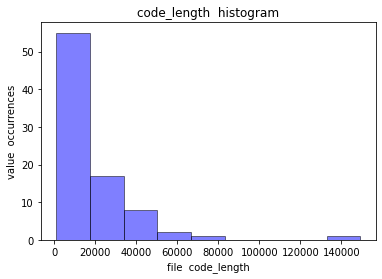

In [12]:
# Print statistical information about the length of each file
display_stats(corpus_df, 'code_length')
display_hist(corpus_df, 'code_length')

~~Printing metrics for all data in column [file_ccn]~~
Min = 2
Max = 516
Average = 47.75
Median = 27.0
Standard Deviation = 75.1687
0.95 of data points fall between 31.3394 and 64.1606
9


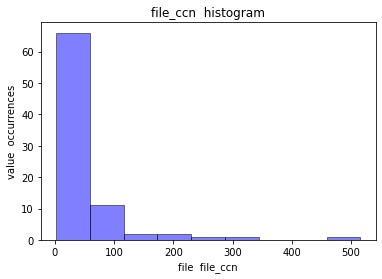

In [13]:
# Print statistical information about the cyclomatic complexity per file
display_stats(corpus_df, 'file_ccn')
display_hist(corpus_df, 'file_ccn')

~~Printing metrics for all data in column [file_nloc]~~
Min = 33
Max = 2353
Average = 337.119
Median = 242.0
Standard Deviation = 346.8797
0.95 of data points fall between 261.3894 and 412.8487
8


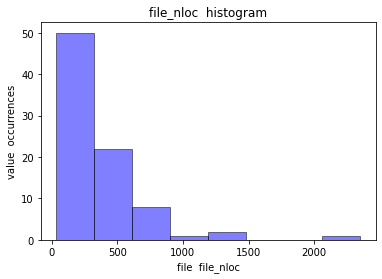

In [14]:
# Print statistical information about the number of lines of code per file
display_stats(corpus_df, 'file_nloc')
display_hist(corpus_df, 'file_nloc')

~~Printing metrics for all data in column [num_funcs]~~
Min = 2
Max = 60
Average = 11.9286
Median = 7.5
Standard Deviation = 11.1289
0.95 of data points fall between 9.499 and 14.3582
7


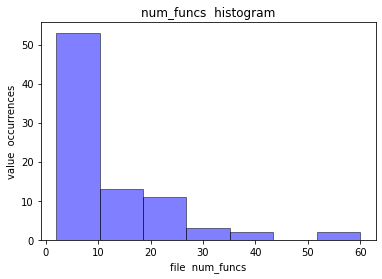

In [15]:
# Print statistical information about the number of functions per file
display_stats(corpus_df, 'num_funcs')
display_hist(corpus_df, 'num_funcs')

~~Printing metrics for all data in column [avg_func_ccn]~~
Min = 1.0
Max = 12.5882
Average = 3.2271
Median = 2.5147
Standard Deviation = 2.1763
0.95 of data points fall between 2.752 and 3.7022
7


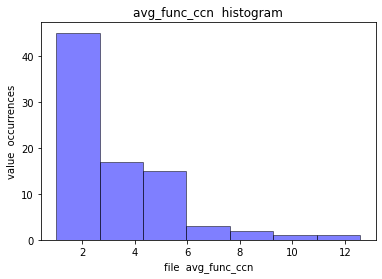

In [16]:
# Print statistical information about the average function cyclomatic complexities per file
display_stats(corpus_df, 'avg_func_ccn')
display_hist(corpus_df, 'avg_func_ccn')

~~Printing metrics for all data in column [avg_func_nloc]~~
Min = 10.0
Max = 59.4
Average = 25.6371
Median = 22.4524
Standard Deviation = 11.3946
0.95 of data points fall between 23.1495 and 28.1247
5


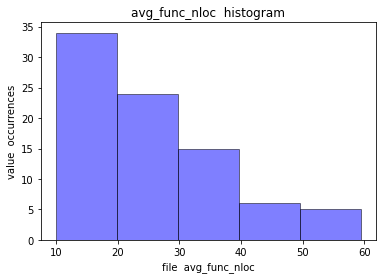

In [17]:
# Print statistical information about the average function cyclomatic complexity per file
display_stats(corpus_df, 'avg_func_nloc')
display_hist(corpus_df, 'avg_func_nloc')

In [18]:
pd.set_option('display.expand_frame_repr', False)
corpus_df.head(20)

,system,name,ground_truth,contents,code_length,file_ccn,file_nloc,num_funcs,avg_func_ccn,avg_func_nloc
0,None,InserisciBeniServizi.java,src,package interfacce;\nimport java.awt.*;\nimpor...,6941,33,313,6,5.500000,50.500000
1,None,us900.c,src,/*--------------------------------------------...,32706,34,466,14,2.428571,32.500000
2,None,est_client.c,src,/*\n * Utility function to set the certificate...,149212,516,2353,58,8.896552,40.568966
3,None,us1060.c,src,/*--------------------------------------------...,21254,37,329,11,3.363636,20.727273
4,None,PrenotazioniScadute.java,src,package interfacce;\nimport java.awt.*;\nimpor...,4242,11,110,5,2.200000,17.800000
5,None,VediCliente.java,src,package interfacce;\nimport java.awt.*;\nimpor...,2614,4,78,4,1.000000,16.750000
6,None,AggiungiSoggiornante.java,src,package interfacce;\nimport java.awt.*;\nimpor...,3393,10,102,5,2.000000,16.600000
7,None,VediCommissione.java,src,package interfacce;\nimport java.awt.*;\nimpor...,1311,2,50,2,1.000000,19.500000
8,None,MascheraDisponibilita.java,src,package interfacce;\nimport java.awt.*;\nimpor...,8440,19,199,5,3.800000,34.800000
9,None,InserisciSoggiornante.java,src,package interfacce;\nimport java.awt.*;\nimpor...,3838,19,127,4,4.750000,28.250000


In [19]:
pd.set_option('display.expand_frame_repr', False)
corpus_df

,system,name,ground_truth,contents,code_length,file_ccn,file_nloc,num_funcs,avg_func_ccn,avg_func_nloc
0,None,InserisciBeniServizi.java,src,package interfacce;\nimport java.awt.*;\nimpor...,6941,33,313,6,5.500000,50.500000
1,None,us900.c,src,/*--------------------------------------------...,32706,34,466,14,2.428571,32.500000
2,None,est_client.c,src,/*\n * Utility function to set the certificate...,149212,516,2353,58,8.896552,40.568966
3,None,us1060.c,src,/*--------------------------------------------...,21254,37,329,11,3.363636,20.727273
4,None,PrenotazioniScadute.java,src,package interfacce;\nimport java.awt.*;\nimpor...,4242,11,110,5,2.200000,17.800000
...,...,...,...,...,...,...,...,...,...,...
79,None,VediPrenotazione.java,src,package interfacce;\nimport java.awt.*;\nimpor...,979,4,33,2,2.000000,10.000000
80,None,MascheraAddebiti.java,src,package interfacce;\nimport java.awt.*;\nimpor...,17599,59,378,17,3.470588,21.058824
81,None,InserisciCommissioni.java,src,package interfacce;\nimport java.awt.*;\nimpor...,1829,6,63,3,2.000000,17.666667
82,None,est_server_http.c,src,static pthread_t pthread_self (void)\n{\n r...,58103,302,1203,60,5.033333,20.050000


In [0]:
"https://github.com/priv-kweihmann/multimetric"


In [0]:
"https://books.google.com/books?id=DxuGi5h2-HEC&pg=PA140&lpg=PA140&dq=do+header+files+in+c+have+a+cyclomatic+complexity&source=bl&ots=0WxxjeX9rR&sig=ACfU3U1QnoKnwrsj4YbSQxATeaoYMvBWwg&hl=en&sa=X&ved=2ahUKEwijtqKxhJXoAhUSXa0KHctQD38Q6AEwAnoECAkQAQ#v=onepage&q=do%20header%20files%20in%20c%20have%20a%20cyclomatic%20complexity&f=false"
"The abover link goes to an article discussing cyclomatic complexity and c header files"

# Scratch Code (Testing)

In [21]:
!pip install multimetric

     |████████████████████████████████| 921kB 6.8MB/s 
  Created wheel for multimetric: filename=multimetric-1.1.3-cp36-none-any.whl size=20170 sha256=0d755e6c6634a50c74264bff0a29dab99642f5051bf7c6ad1c2d3d637a2b1403
  Stored in directory: /root/.cache/pip/wheels/6d/c7/81/52b4323f26674931ea81e0d7589a71081e05e88426004c5331
Successfully built multimetric
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: Pygments 2.1.3
    Uninstalling Pygments-2.1.3:
      Successfully uninstalled Pygments-2.1.3


In [0]:
import multimetric

In [0]:
multimetric.rea

In [0]:
print(round(1236721.8237468732, 3))

1236721.824


In [0]:
!pip install lizard

In [0]:
import subprocess
import json
def add_lizard_mccabe_metrics(df, col):
    mccabe = []
    sloc = []
    comments = []
    ratio = []
    for i in range(len(df)):
        if i == 99:
            print("At file #100", end="")
        if ((i + 1) % 200) == 0:
            print(", file #" + str(i + 1), end="")
        ext = df["file_name"][i].split('.')[-1]
        if ext == 'h':
            ext = 'c'
        with open(f"temp_file.{ext}", "w", encoding='UTF-8') as fp:
            fp.write(df[col][i])
        out = subprocess.Popen(['metrics', '-q', '--format=json', f"temp_file.{ext}"], 
                               stdout=subprocess.PIPE, 
                               stderr=subprocess.STDOUT)
        stdout,stderr = out.communicate()
        metrics_data = json.loads(stdout)
        mccabe.append(metrics_data['files'][f"temp_file.{ext}"]['mccabe'])
        sloc.append(metrics_data['files'][f"temp_file.{ext}"]['sloc'])
        comments.append(metrics_data['files'][f"temp_file.{ext}"]['comments'])
        ratio.append(metrics_data['files'][f"temp_file.{ext}"]['ratio_comment_to_code'])
#         print(mccabe_data['files'][f'temp_file.{LANGUAGE}'].keys())
        os.remove(f"temp_file.{ext}")
    df["complexity"] = mccabe
    df["code_lines"] = sloc
    df["comments"] = comments
    df["ratio_comment_to_code"] = ratio
    return df

In [0]:
!lizard source_code/est.c

  NLOC    CCN   token  PARAM  length  location  
------------------------------------------------
       7      1     35      2      11 est_logger_stderr@9-19@source_code/est.c
      11      2     53      2      16 est_log_msg@27-42@source_code/est.c
      14      3     66      3      24 est_log@46-69@source_code/est.c
      18      2    154      1      23 printStackTrace@73-95@source_code/est.c
      18      5     91      1      31 est_log_backtrace@99-129@source_code/est.c
       3      1      9      1       3 est_get_version@136-138@source_code/est.c
       3      1      9      1       3 est_get_api_level@148-150@source_code/est.c
       7      2     43      1       9 est_log_version@156-164@source_code/est.c
      10      2     46      2      16 est_init_logger@181-196@source_code/est.c
       4      1     11      1       4 est_enable_backtrace@213-216@source_code/est.c
      42      9    202      3      52 est_read_x509_request@239-290@source_code/est.c
      29      5    135     

In [0]:
!lizard thing.py

  NLOC    CCN   token  PARAM  length  location  
------------------------------------------------
       8      3     35      0      10 func@1-10@thing.py
1 file analyzed.
NLOC    Avg.NLOC  AvgCCN  Avg.token  function_cnt    file
--------------------------------------------------------------
      8       8.0     3.0       35.0         1     thing.py

No thresholds exceeded (cyclomatic_complexity > 15 or length > 1000 or nloc > 1000000 or parameter_count > 100)
Total nloc   Avg.NLOC  AvgCCN  Avg.token   Fun Cnt  Warning cnt   Fun Rt   nloc Rt
------------------------------------------------------------------------------------------
         8       8.0     3.0       35.0        1            0      0.00    0.00


In [0]:
!metrics source_code/est.c

Metrics Summary:
Files                       Language        SLOC Comment McCabe 
----- ------------------------------ ----------- ------- ------ 
    1                         Python           9       0      3 
----- ------------------------------ ----------- ------- ------ 
    1                          Total           9       0      3 


In [0]:
import lizard

In [0]:
i = lizard.analyze_file("source_code/est.c")

In [0]:
print(i.CCN)

204


In [0]:
print(i.__dict__)

{'filename': 'source_code/est.c', 'nloc': 1005, 'function_list': [<lizard.FunctionInfo object at 0x7f137fc5fc18>, <lizard.FunctionInfo object at 0x7f137fc5fd68>, <lizard.FunctionInfo object at 0x7f137fc5fb00>, <lizard.FunctionInfo object at 0x7f137fc5ff28>, <lizard.FunctionInfo object at 0x7f137fc5ff98>, <lizard.FunctionInfo object at 0x7f137fc5ffd0>, <lizard.FunctionInfo object at 0x7f137fc5f978>, <lizard.FunctionInfo object at 0x7f137fc6b898>, <lizard.FunctionInfo object at 0x7f137fc6b080>, <lizard.FunctionInfo object at 0x7f137fc6b0f0>, <lizard.FunctionInfo object at 0x7f137fc6b160>, <lizard.FunctionInfo object at 0x7f137fc6b128>, <lizard.FunctionInfo object at 0x7f137fc6b2b0>, <lizard.FunctionInfo object at 0x7f137fc6b208>, <lizard.FunctionInfo object at 0x7f137fc6b3c8>, <lizard.FunctionInfo object at 0x7f137fc6b470>, <lizard.FunctionInfo object at 0x7f137fc6b550>, <lizard.FunctionInfo object at 0x7f137fc6b5c0>, <lizard.FunctionInfo object at 0x7f137fc6b668>, <lizard.FunctionInfo o

In [0]:
for i in range(len(i.function_list)):
  

SyntaxError: ignored

In [0]:
print(i.function_list[0].__dict__)

{'cyclomatic_complexity': 3, 'nloc': 8, 'token_count': 35, 'name': 'func', 'long_name': 'func( )', 'start_line': 1, 'end_line': 10, 'parameters': [], 'filename': 'thing.py', 'top_nesting_level': 0, 'length': 10, 'fan_in': 0, 'fan_out': 0, 'general_fan_out': 0}


In [0]:
print(len(i.function_list))

37


In [0]:
i

In [0]:
!metrics thing.py

Metrics Summary:
Files                       Language        SLOC Comment McCabe 
----- ------------------------------ ----------- ------- ------ 
    1                         Python          32       0      9 
----- ------------------------------ ----------- ------- ------ 
    1                          Total          32       0      9 


In [0]:
thing = lizard.analyze_file("thing.py")
print(thing.__dict__)
print(thing.CCN)
for i in range(len(thing.function_list)):
    print(thing.function_list[i].__dict__)


{'filename': 'thing.py', 'nloc': 32, 'function_list': [<lizard.FunctionInfo object at 0x7f47bee93198>, <lizard.FunctionInfo object at 0x7f47bee932e8>, <lizard.FunctionInfo object at 0x7f47bee933c8>, <lizard.FunctionInfo object at 0x7f47bee93630>, <lizard.FunctionInfo object at 0x7f47bee935f8>, <lizard.FunctionInfo object at 0x7f47bee93400>], 'token_count': 145}
12
{'cyclomatic_complexity': 1, 'nloc': 2, 'token_count': 10, 'name': '__init__', 'long_name': '__init__( self )', 'start_line': 5, 'end_line': 6, 'parameters': ['self'], 'filename': 'thing.py', 'top_nesting_level': 1, 'length': 2, 'fan_in': 0, 'fan_out': 0, 'general_fan_out': 0}
{'cyclomatic_complexity': 1, 'nloc': 2, 'token_count': 10, 'name': '__init__', 'long_name': '__init__( self )', 'start_line': 9, 'end_line': 10, 'parameters': ['self'], 'filename': 'thing.py', 'top_nesting_level': 2, 'length': 2, 'fan_in': 0, 'fan_out': 0, 'general_fan_out': 0}
{'cyclomatic_complexity': 1, 'nloc': 2, 'token_count': 10, 'name': 'delete',

In [0]:
thing.filename

'source_code/est.c'

In [0]:
thing.nloc

1005

In [0]:
print(thing.functions_average)

<bound method FileInformation.functions_average of <lizard.FileInformation object at 0x7f5ed935c978>>


In [0]:
i = lizard.analyze_file.analyze_source_code("AllTests.cpp", "int foo(){}")

In [0]:
i.__dict__

{'filename': 'AllTests.cpp',
 'function_list': [<lizard.FunctionInfo at 0x7f137fbacc18>],
 'nloc': 1,
 'token_count': 6}

In [0]:
i.CCN

1

In [0]:
lizard.analyze_file.analyze_source_code("AllTests.py", "def foo():\n\tif (True): \n\tprint('HI')").CCN

2

In [0]:
import subprocess
import json
def add_mccabe_metrics(df, col):
    mccabe = []
    sloc = []
    comments = []
    ratio = []
    for i in range(len(df)):
        if i == 99:
            print("At file #100", end="")
        if ((i + 1) % 200) == 0:
            print(", file #" + str(i + 1), end="")
        ext = df["file_name"][i].split('.')[-1]
        if ext == 'h':
            ext = 'c'
        with open(f"temp_file.{ext}", "w", encoding='UTF-8') as fp:
            fp.write(df[col][i])
        out = subprocess.Popen(['metrics', '-q', '--format=json', f"temp_file.{ext}"], 
                               stdout=subprocess.PIPE, 
                               stderr=subprocess.STDOUT)
        stdout,stderr = out.communicate()
        metrics_data = json.loads(stdout)
        mccabe.append(metrics_data['files'][f"temp_file.{ext}"]['mccabe'])
        sloc.append(metrics_data['files'][f"temp_file.{ext}"]['sloc'])
        comments.append(metrics_data['files'][f"temp_file.{ext}"]['comments'])
        ratio.append(metrics_data['files'][f"temp_file.{ext}"]['ratio_comment_to_code'])
#         print(mccabe_data['files'][f'temp_file.{LANGUAGE}'].keys())
        os.remove(f"temp_file.{ext}")
    df["complexity"] = mccabe
    df["code_lines"] = sloc
    df["comments"] = comments
    df["ratio_comment_to_code"] = ratio
    return df